# goes-orthorectify

Orthorectify and clip a GOES ABI image using the mapping created by goes-make-orth-map

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os

#import warnings
#warnings.filterwarnings('ignore')

#### Open a GOES-16 image

In [156]:
#image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\21\ABI-L1b-RadC\15\C02\OR_ABI-L1b-RadC-M4C02_G16_s20171111520224_e20171111525027_c20171111525034.nc'
image_path =  r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\04\21\ABI-L1b-RadC\17\C14\OR_ABI-L1b-RadC-M4C14_G16_s20171111750224_e20171111755027_c20171111755074.nc'
#image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2019\04\16\ABI-L1b-RadC\18\C02\OR_ABI-L1b-RadC-M6C02_G16_s20191061801182_e20191061803555_c20191061803598.nc'

In [157]:
image = xr.open_dataset(image_path)
#print(image)

#### Open the ortho mapping:

In [158]:
tuol_test = xr.open_dataset('test_map_tuol_2017.nc')
#print(tuol_test)

#### Does the projection info in the image match our mapping?

In [159]:
print(image.goes_imager_projection.longitude_of_projection_origin)
print(tuol_test.longitude_of_projection_origin)

-89.5
-89.5


#### Map and clip the image to the pixel map

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


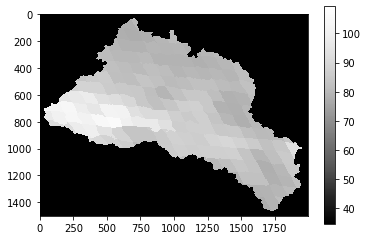

In [160]:
# this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
# in the same shape and size as the original DEM
rad_values = image.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
print(rad_values.shape)
plt.imshow(rad_values, cmap='Greys_r')
plt.colorbar()

#### Save this out as a GeoTIFF for now

In [161]:
dem_filename = 'dem.tif'
dem = rio.open(dem_filename)

import rasterio as rio
# Open and write to this new file
with rio.open('test_ortho3.tif', 
              'w', 
              driver='GTiff',
              height=rad_values.shape[0],
              width=rad_values.shape[1],
              count=1, 
              dtype='float32',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(rad_values, 1)

Function for making a quick elevation versus radiance plot for the IR channels

In [148]:
def make_elev_rad_plot(fname,rad_values):
    rad_da = xr.DataArray(rad_values, 
                      dims=('y','x'),
                      coords={'longitude': (['x'], tuol_test.longitude),
                              'latitude': (['y'], tuol_test.latitude)})
    #rad_da.plot(x='longitude', y='latitude')
    tuol_test['rad'] = rad_da
    plt.plot(tuol_test.rad,tuol_test.elevation,'.',c='tab:blue',alpha=0.01);
    plt.xlabel('Radiance')
    plt.ylabel('Elevation')
    plt.xlim((50,100))
    plt.savefig(fname+'_elev_vs_radiance.jpg')
    plt.close()

***

## Orthorectify a time series of GOES images

In [149]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

In [150]:
#  all the observations from a directory path
path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\04\21'
print('Load all observations from the directory provided')
file_list = []
try:
    file_list.append(getListOfFiles(path))
except FileNotFoundError:
    print('Could not find files at {}'.format(path))

Load all observations from the directory provided


In [151]:
file_list = file_list[0]

For each file, orthorectify and output a thumbnail image


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


KeyboardInterrupt: 

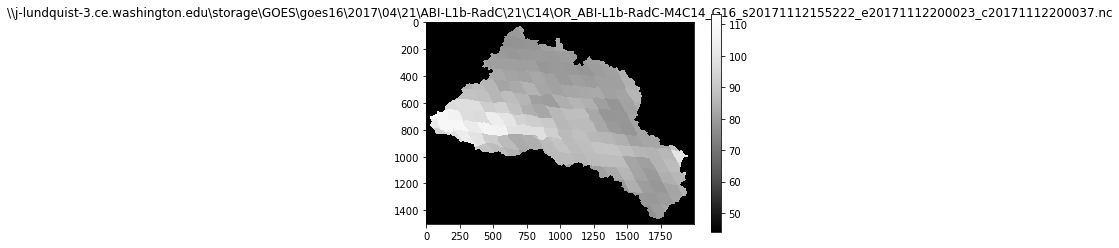

In [152]:
# For each file, orthorectify and output a GeoTiff
print('For each file, orthorectify and output a thumbnail image')

for filename in file_list:
    with xr.open_dataset(filename) as f:
        # this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
        # in the same shape and size as the original DEM
        s = f.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
        print(s.shape)
        make_elev_rad_plot(filename,s)
        plt.imshow(s, cmap='Greys_r')
        plt.colorbar()
        plt.title(filename)
        plt.tight_layout()
        plt.savefig(filename+'_orthorectified.jpg')
        plt.close()

In [ ]:
# open this entire dataset as a "multi-file dataset"
# For each file, orthorectify and output a GeoTiff
print('Open as multi-file dataset')
print('For each file, orthorectify and output a GeoTiff')

with xr.open_mfdataset(file_list[0], concat_dim=['t']) as g:
    # this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
    # in the same shape and size as the original DEM
    s = g.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
    print(s.shape)
    #plt.imshow(s, cmap='Greys_r')
    #plt.colorbar()
    #plt.title(filename)
    #plt.tight_layout()
    #plt.savefig(filename+'.jpg')
    #plt.close()